In [3]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

In [4]:
from time import time
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

## User input

In [5]:
sample_prefix = 'E:\\Ashlee\\PacBio\\20190124_B2_nucleosomes\\Blank_IBG\\m190124_161012_42131_c000469372559900001500000112312190_s1_p0'

## Load data

In [6]:
trc_filename = sample_prefix + '.trc.h5'
mcd_filename = sample_prefix + '.mcd.h5'
upd_filename = sample_prefix + '.upd.h5'
meta_filename = sample_prefix + '.metadata.xml'

trc_file = h5py.File(trc_filename, 'r')
mcd_file = h5py.File(mcd_filename, 'r')
upd_file = h5py.File(upd_filename, 'r')

# Load data in trace file
dset = trc_file['TraceData']
raw_traces = dset['Traces']
decode = dset['Codec']['Decode']
n_traces = raw_traces.shape[0]
n_frames = raw_traces.shape[2]
decode_array = np.array(decode)

# Load data in upd file
upd_TD = upd_file['TraceData']
hole_xy_plot = upd_TD['HoleXYPlot'] # (x,y) coordinates for each well
hole_status = upd_TD['HoleStatus'] # fiducials

# Extract frame rate from metadata
meta_tree = ET.parse(meta_filename)
root = meta_tree.getroot()
for keyval in root.iter('{http://pacificbiosciences.com/PAP/Metadata.xsd}KeyValue'):
    if keyval.attrib['key'] == 'MovieFPS':
        fps = int(keyval.text)
        frame_rate = 1.0/fps # seconds
        break

# For plotting
time_axis = np.arange(n_frames)*frame_rate
colors = ['green', (0, 1, 0), 'red', 'orange']
lasers = ['Cy3', 'Cy3.5', 'Cy5', 'Cy5.5']

In [7]:
traces = raw_traces # skipping decode step to save memory

## Plot intensity distributions

In [8]:
avg_intens = np.mean(traces, axis=2)

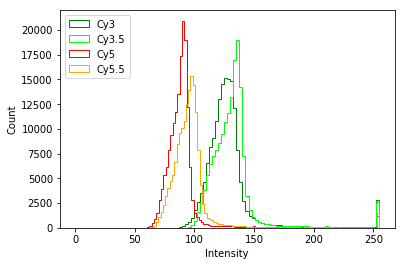

In [9]:
for i in range(4):
    avg_intens_i = avg_intens.T[i]
    min_i = min(avg_intens_i)
    max_i = max(avg_intens_i)
    plt.hist(avg_intens_i, bins=100, range=[min_i, max_i], histtype='step', color=colors[i])
    
    
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.legend(lasers)

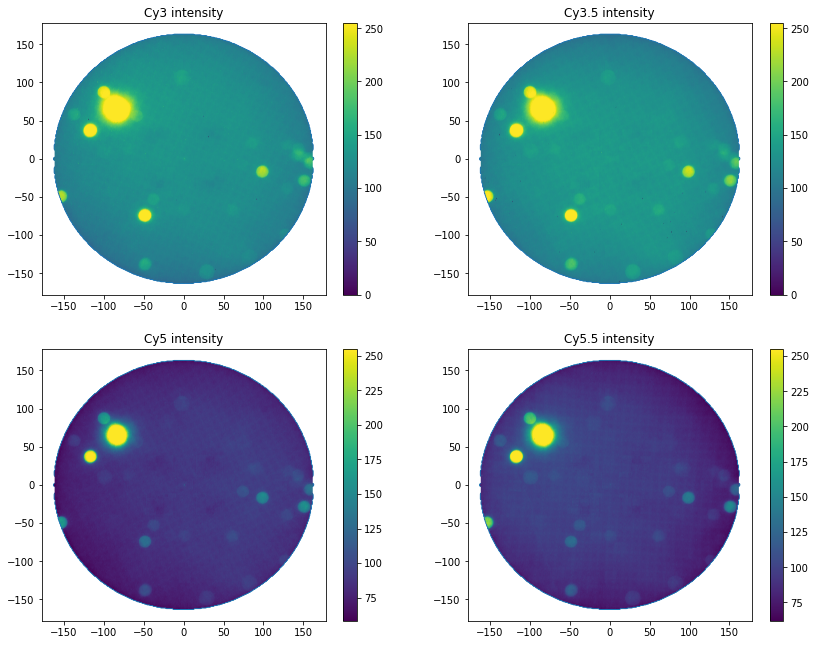

In [10]:
# for i in range(4):
#     plt.figure()
#     plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], hole_status)
#     plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], 1, avg_intens.T[i]/300)
#     plt.title(lasers[i] + ' intensity')
#     plt.show()

plt.figure(figsize=(14, 11))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], hole_status)
    plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], 1, avg_intens.T[i])
    plt.title(lasers[i] + ' intensity')
    plt.colorbar()

plt.savefig(sample_prefix + '_grid.png')
plt.show()

## Plot variance distributions

In [ ]:
# var = np.log10(np.var(traces, axis=2) + 1e-6)

In [ ]:
# for i in range(4):
#     var_i = var.T[i]
#     min_i = 0
#     max_i = max(var_i)
#     plt.hist(var_i, bins=100, range=[min_i, max_i], histtype='step', color=colors[i])
    
# plt.xlabel('log10(Variance)')
# plt.ylabel('Count')
# plt.legend(lasers)

In [ ]:
# Plot variance over the grid

# for i in range(4):
#     plt.figure()
#     plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], hole_status)
#     plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], 1, var.T[i])
#     plt.title('log10(Variance) of ' + lasers[i])
#     plt.show()

## View a trace

In [ ]:
# # i = 112542 # is a good example
# i = 30256
# # i = np.random.randint(0, n_traces)
# trace = traces[i]
# for j in range(4):
#     plt.plot(time_axis, trace[j], color=colors[j])
#     j += 1 

# plt.xlabel('Time (s)')
# plt.ylabel('Intensity')
# plt.legend(lasers, bbox_to_anchor=(0.75, 0.5, 0.5, 0.5))

In [ ]:
# plt.imshow(traces[:200, 2, :])
# plt.colorbar()

In [ ]:
# plt.figure(figsize=(10, 4))
# plt.imshow(traces[(112542-50):(112542+50), 2, :])
# plt.colorbar()
# plt.title("Cy5 traces stacked")
# plt.xlabel("Frame")
# plt.ylabel('Wells')
# plt.savefig(sample_prefix + '_cy5_stacked_example.png', dpi=300)

## Plot average intensity over time for each color

In [ ]:
# avg_trace = np.zeros((4, n_frames))
# for i in range(4):
#     avg_trace[i] = np.mean(traces[:][:][i], axis=0)

In [ ]:
# for i in range(4):
#     plt.plot(time_axis, avg_trace[i], color=colors[i])

# plt.xlabel('Time (s)')
# plt.ylabel('Intensity')
# plt.legend(lasers, bbox_to_anchor=(0.75, 0.5, 0.5, 0.5))

## Sort by correlation

In [16]:
# zero-center the traces
centered_traces = np.zeros((n_traces, 2, n_frames), dtype=np.int32)
for i in range(n_traces):
    centered_traces[i, 0] = traces[i, 0] - avg_intens[i, 0]
    centered_traces[i, 1] = traces[i, 3] - avg_intens[i, 3]

In [ ]:
ct_avg_intens = np.mean(centered_traces, axis=2)
for i in range(2):
    avg_intens_i = ct_avg_intens.T[i]
    min_i = min(avg_intens_i)
    max_i = max(avg_intens_i)
    plt.hist(avg_intens_i, bins=100, range=[min_i, max_i], histtype='step', color=colors[i])
    
    
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.legend(lasers)

In [ ]:
centered_traces[0][0]

In [ ]:
i = np.random.randint(0, n_traces)
ct = centered_traces[i]
for j in range(2):
    plt.plot(time_axis, ct[j], color=colors[j])
    j += 1 

plt.xlabel('Time (s)')
plt.ylabel('Intensity')
plt.legend(lasers, bbox_to_anchor=(0.75, 0.5, 0.5, 0.5))

In [ ]:
# Compute cross-correlation
corr_list = np.zeros(n_traces,dtype=np.int64)
for i in range(n_traces):
    cy3 = centered_traces[i][0]
    cy5 = centered_traces[i][1]
    corr_list[i] = np.correlate(cy3, cy5)

sorting_index = np.argsort(corr_list)

In [ ]:
plt.figure(figsize=(15, 20))
for i in range(10):
    plt.subplot(5, 2, i+1)
    st = traces[sorting_index[i]]
    for j in range(4):
        plt.plot(time_axis, st[j], color=colors[j])
        j += 1 

    plt.xlabel('Time (s)')
    plt.ylabel('Intensity')
    plt.legend(lasers, bbox_to_anchor=(0.75, 0.5, 0.5, 0.5))
    i = i + 1
# plt.savefig("10 min Bottem 50 anticorrelated traces.png")

## K-means clustering

In [ ]:
corr_list.shape

In [ ]:
avg_intens.shape

In [ ]:
plt.scatter(corr_list, avg_intens[:, 0], s=0.1)
plt.ylim([100, 260])
plt.figure()
plt.scatter(corr_list, avg_intens[:, 2], s=0.1)

In [ ]:
scaled_traces = scale(traces[:, [0, 2], :])

In [ ]:
data = traces
n_samples = n_traces
n_features = n_frames
n_clusters = 2

def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

bench_k_means(KMeans(init='k-means++', n_clusters=n_clusters, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_clusters).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)
print(82 * '_')

# #############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:
corr_list[sorting_index]

In [ ]:
a = plt.hist(corr_list, bins=50, range=[-2e6, 4e6])

In [ ]:
# anti_list = []
# for i in range(n_traces):
#     if corr_list[i] < 0:
#         anti_list.append(i)

In [ ]:
# n_anti = len(anti_list)
# start = 0
# end = 10
# init_intens = np.zeros((2, n_anti))
# for i in range(len(anti_list)):
#     index = anti_list[i]
#     trace = traces[i]
    
#     for j in range(2):
#         dec_trace = decode_array[trace[j, start:end]]
#         init_intens[j, i] = np.mean(dec_trace[j])

In [ ]:
# plt.hist(init_intens[0])
# plt.hist(init_intens[1])

In [ ]:
n_anti = len(anti_list)
start = 5890
end = 5900
final_intens = np.zeros((2, n_anti))
for i in range(len(anti_list)):
    index = anti_list[i]
    trace = traces[i]
    for j in range(2):
        dec_trace = decode_array[trace[j, start:end]]
        final_intens[j, i] = np.mean(dec_trace[j])

In [ ]:
trace.shape

In [ ]:
plt.hist(final_intens[0, :])
plt.hist(final_intens[1, :])

In [ ]:
anti_list = np.array(anti_list)
diff_list = final_intens - init_intens
temp_indices = np.argsort(diff_list[0])
diff_sort_indices_cy3 = anti_list[temp_indices]

In [ ]:
plt.figure(figsize=(15, 100))
for i in range(50):
    plt.subplot(25, 2, i+1)
    st = traces[diff_sort_indices_cy3[i]]
    for j in range(4):
        plt.plot(time_axis, st[j], color=colors[j])
        j += 1 

    plt.xlabel('Time (s)')
    plt.ylabel('Intensity')
    plt.legend(lasers, bbox_to_anchor=(0.75, 0.5, 0.5, 0.5))
    i = i + 1

In [ ]:
anti_list = np.array(anti_list)
temp_indices = np.argsort(final_intens[0])
sort_indices_cy3 = anti_list[temp_indices]

In [ ]:
plt.figure(figsize=(15, 100))
for i in range(50):
    plt.subplot(25, 2, i+1)
    st = traces[sort_indices_cy3[i]]
    for j in range(4):
        plt.plot(time_axis, st[j], color=colors[j])
        j += 1 

    plt.xlabel('Time (s)')
    plt.ylabel('Intensity')
    plt.legend(lasers, bbox_to_anchor=(0.75, 0.5, 0.5, 0.5))
    i = i + 1

In [ ]:
final_intens[0][temp_indices]

## Sort by change in intensity

In [ ]:
init_intens = np.zeros((2, n_traces))
final_intens = np.zeros((2, n_traces))
for i in range(n_traces):
    trace = traces[i]
    init_intens[0, i] = np.mean(trace[0, :10])
    final_intens[0, i] = np.mean(trace[0, 5890:])
    init_intens[1, i] = np.mean(trace[2, :10])
    final_intens[1, i] = np.mean(trace[2, 5890:])

diff = final_intens - init_intens

diff_sort_cy5 = np.argsort(diff[1])

In [ ]:
plt.hist(diff[1], bins=100)

In [ ]:
plt.figure(figsize=(15, 40))
for i in range(20):
    plt.subplot(10, 2, i+1)
    st = traces[diff_sort_cy5[i+100]]
    for j in range(4):
        plt.plot(time_axis, st[j], color=colors[j])
        j += 1 

    plt.xlabel('Time (s)')
    plt.ylabel('Intensity')
    plt.legend(lasers, bbox_to_anchor=(0.75, 0.5, 0.5, 0.5))
    i = i + 1

In [ ]:
diff_sort_cy3 = np.argsort(diff[0])

In [ ]:
plt.figure(figsize=(15, 40))
for i in range(20):
    plt.subplot(10, 2, i+1)
    st = traces[diff_sort_cy3[i+100]]
    st[0] = st[0]-120
    st[2] = st[2]-65
    for j in [0, 2]:
        plt.plot(time_axis, st[j], color=colors[j])
        j += 1 

    plt.xlabel('Time (s)')
    plt.ylabel('Intensity')
    plt.legend(lasers, bbox_to_anchor=(0.75, 0.5, 0.5, 0.5))
    i = i + 1

In [ ]:
don_list = init_intens[0]
acc_list = init_intens[1]
fret_list = acc_list/(donor_list + acc_list)

In [ ]:
plt.hist(fret_list, bins=60, range=[0, 1])

In [ ]:
plt.hist(don_list, bins=100)
plt.hist(acc_list, bins=100)

In [ ]:
green_filter = np.zeros((n_traces,), dtype = bool)
red_filter = np.zeros((n_traces, ), dtype = bool)
green_min = 200
green_max = 250
red_min = 140
red_max = 250

In [ ]:
for i in range(n_traces):
    if (don_list[i] > green_min and don_list[i] < green_max):
        green_filter[i] = 1
    if (acc_list[i] > red_min and acc_list[i] < red_max):
        red_filter[i] = 1

In [ ]:
plt.hist(don_list[green_filter])
plt.hist(acc_list[red_filter])

In [ ]:
gr_filter = np.zeros((n_traces,), dtype=bool)
n_sele = 0
for i in range(n_traces):
    gr_filter[i] = green_filter[i] and red_filter[i]
    if gr_filter[i] == True:
        n_sele += 1

In [ ]:
sele_traces = np.zeros((n_sele, 4, n_frames), dtype=np.uint8)
j = 0
for i in range(n_traces):
    if gr_filter[i]:
        sele_traces[j] = traces[i]
        j += 1

In [ ]:
n_sele

In [ ]:
plt.figure(figsize=(15, 100))
for i in range(100):
    plt.subplot(50, 2, i+1)
    st = sele_traces[i]
    for j in range(4):
        plt.plot(time_axis, st[j], color=colors[j])
        j += 1 

    plt.xlabel('Time (s)')
    plt.ylabel('Intensity')
    plt.legend(lasers, bbox_to_anchor=(0.75, 0.5, 0.5, 0.5))
    i = i + 1